# Load and preprocess images

Load and preprocess an image dataset in three ways: (1)high-level Keras preprocessing [utilities] and [layers]; (2)write own input pipeline from scratch [using tf.data] (3)download a dataset from the large [catalog]

## Setup

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
print(tf.__version__)

2.5.0


### Download the flowers dataset

The flowers dataset contains 5 sub-directories, one per class:

```
flowers_photos/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)
data_dir = pathlib.Path(data_dir)

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Each directory contains images of that type of flower. 

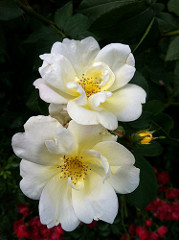

In [5]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

## Load using `tf.keras.preprocessing`

### Create a dataset

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use a validation split when developing classification model. 80% of the images for training and 20% for validation.

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


Class names can be found in the `class_names` attribute on these datasets.

In [9]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### Visualize the data

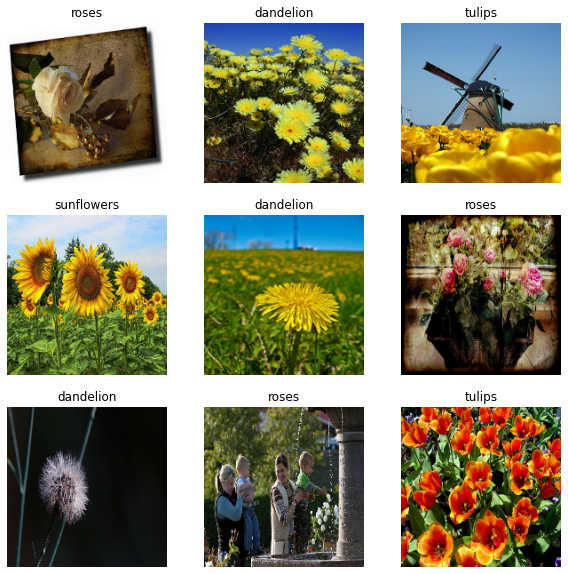

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Train a model using these datasets by passing them to `model.fit` (shown later in this tutorial). 

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension referes to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are the corresponding labels to the 32 images.


### Standardize the data


The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network, as the input values small should be as small as possible. Standardize values to be in the `[0, 1]` range by using the `tf.keras.layers.experimental.preprocessing.Rescaling` layer.

In [12]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

Apply it to the dataset by calling map:

In [13]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 0.96902645


Or, include the layer inside the model definition to simplify deployment. Second approach will be used here.

### Configure the dataset for performance

Buffered prefetching will be used to yield data from disk without having I/O become blocking. 

`.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training model. 

`.prefetch()` overlaps data preprocessing and model execution while training. 

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Train a model

Train a simple model using the datasets just prepared.

In [15]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [16]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [17]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 11s 42ms/step - loss: 1.3317 - accuracy: 0.4220 - val_loss: 1.1995 - val_accuracy: 0.5327
Epoch 2/3
92/92 [==============================] - 2s 21ms/step - loss: 1.0606 - accuracy: 0.5766 - val_loss: 0.9982 - val_accuracy: 0.6213
Epoch 3/3
92/92 [==============================] - 2s 21ms/step - loss: 0.8758 - accuracy: 0.6594 - val_loss: 0.9151 - val_accuracy: 0.6526


## Using `tf.data` for finer control

The above `tf.keras.preprocessing` utilities are a convenient way to create a `tf.data.Dataset` from a directory of images. For finer grain control, it can be done by writing own input pipeline using `tf.data`. 

In [18]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [19]:
for f in list_ds.take(5):
  print(f.numpy())

b'C:\\Users\\Wei\\.keras\\datasets\\flower_photos\\sunflowers\\22416421196_caf131c9fa_m.jpg'
b'C:\\Users\\Wei\\.keras\\datasets\\flower_photos\\dandelion\\2522454811_f87af57d8b.jpg'
b'C:\\Users\\Wei\\.keras\\datasets\\flower_photos\\dandelion\\2780702427_312333ef33.jpg'
b'C:\\Users\\Wei\\.keras\\datasets\\flower_photos\\roses\\15509799653_0562d4a4fa.jpg'
b'C:\\Users\\Wei\\.keras\\datasets\\flower_photos\\tulips\\17078576150_6f272ce73f_n.jpg'


The tree structure of the files can be used to compile a `class_names` list.

In [20]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


Split the dataset into train and validation:

In [21]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [22]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


Write a short function that converts a file path to an `(img, label)` pair:

In [23]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [24]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [25]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

Use `Dataset.map` to create a dataset of `image, label` pairs:

In [26]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [27]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  2


### Configure dataset for performance

To train a model with this dataset, the data should satisfy:

* To be well shuffled.
* To be batched.
* Batches to be available as soon as possible.

These features can be added using the `tf.data` API. 

In [28]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

### Visualize the data

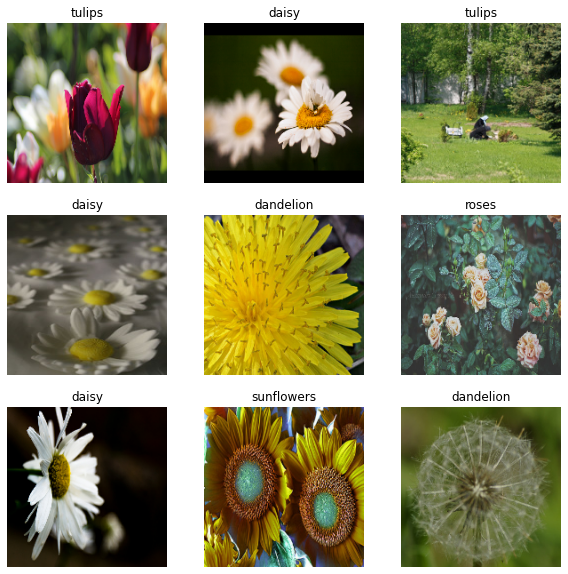

In [29]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

### Continue training the model

In [30]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 21s 178ms/step - loss: 0.7562 - accuracy: 0.7176 - val_loss: 0.7618 - val_accuracy: 0.7044
Epoch 2/3
92/92 [==============================] - 33s 357ms/step - loss: 0.5707 - accuracy: 0.7851 - val_loss: 0.7465 - val_accuracy: 0.7180
Epoch 3/3
92/92 [==============================] - 37s 406ms/step - loss: 0.3908 - accuracy: 0.8607 - val_loss: 0.7720 - val_accuracy: 0.7057
